# Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# We import the data and conduct a study of it's health

In [2]:
#We'll be conducting a study of the JP Morgan stock, we proceed to load it
data = pd.read_csv('./stock_market_data/nyse/csv/JPM.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10680 entries, 0 to 10679
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10680 non-null  object 
 1   Low             10680 non-null  float64
 2   Open            10680 non-null  float64
 3   Volume          10680 non-null  int64  
 4   High            10680 non-null  float64
 5   Close           10680 non-null  float64
 6   Adjusted Close  10680 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 584.2+ KB


In [3]:
#We want to only select the closing price as a target
data_target = data.Close

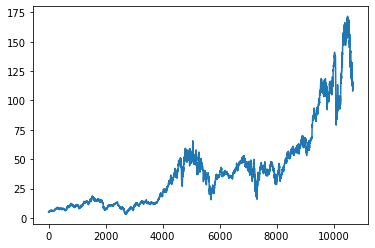

In [4]:
#We can also see the data graphically
plt.plot(data_target, label = 'Price')
plt.show()
plt.close()

In [5]:
#We now want to normalize the data
max_value = data_target.max()
min_value = data_target.min()
normalized_data = (data_target - min_value)/(max_value)
normalized_data = normalized_data.values.reshape(-1,1)

In [6]:
#We create a function to undo the normalization
def denormalizer(value):
    return (value*max_value) + min_value

# We separate the data in train and test as well as creater the sequences

In [7]:
#We create a function that splits the data in 80-20 for train and test as well as create the sequences.
#We'll also turn the data into numpy arrray to later be turned into a torch.tensor
def preparer(dataset, lookback):
    data_raw = dataset
    data =[]
    for index in range(len(data_raw)-lookback):
        data.append(data_raw[index:index+lookback])
        
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    data = np.array(data)
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
lookback = 30 # we chose a sequence lenght of 30 to make it about a month of prediction
x_train, y_train, x_test, y_test = preparer(normalized_data, lookback)

In [9]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (8520, 29, 1)
y_train.shape =  (8520, 1)
x_test.shape =  (2130, 29, 1)
y_test.shape =  (2130, 1)


# Custom dataset that transforms into tensors

In [10]:
class StockDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
        #self.y = torch.unsqueeze(torch.from_numpy(y), dim = -1).float()
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [11]:
#We now create the datasets instances for loading the training and testing data and also the dataloaders instances
train_dataset = StockDataset(x_train,y_train)
test_dataset = StockDataset(x_test, y_test)
train = DataLoader(train_dataset, batch_size = 6)
test = DataLoader(test_dataset, batch_size = 6)

# GRU class 

In [12]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout = 0):
        super(GRU, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_dim = output_dim
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout = 0)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1]) 
        return out

# We create an epoch runner that runs the model and can perform the backpropagation

In [13]:
def run_epoch(dataloader, model, loss_fn, optimizer, is_training = False):
    #We stablish the loss to 0 and set the model to train
    epoch_loss = 0
    if is_training:
        model.train()
    else:
        model.eval()
    #We now go trough every batch in the data loader
    for batch, (x,y) in enumerate(dataloader):
        batchsize = x.shape[0]
        #We clear the memory of the graph
        optimizer.zero_grad()
        #We calculate the output and the loss 
        out = model(x)
        loss = loss_fn(out,y)
        #Now if we are training we proceed with backpropagation
        if is_training:
            loss.backward()
            optimizer.step()
        #We calculate the loss for the epoch
        epoch_loss += (loss.detach().item() / batchsize)
        #Finally we return the loss and the model
        return epoch_loss, model

# Model initialization and training loop

In [14]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
epochs = 100
dropout_ = 0.2

In [15]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout = dropout_)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
training_loss = []
validation_loss = []
for epoch in range(epochs):
    cost, _ = run_epoch(train, model, loss, optimizer, is_training=True)
    training_loss.append(cost)
    print(f'Epoch {epoch+1}/100  - loss: {cost}')
    cost, _ = run_epoch(test, model, loss, optimizer, is_training=False)
    validation_loss.append(cost)

Epoch 1/100  - loss: 0.0021556164138019085
Epoch 2/100  - loss: 0.002469480192909638
Epoch 3/100  - loss: 0.0011014705523848534
Epoch 4/100  - loss: 2.091485900261129e-05
Epoch 5/100  - loss: 0.0003164582303725183
Epoch 6/100  - loss: 0.0006345503885919849
Epoch 7/100  - loss: 0.00042723165825009346
Epoch 8/100  - loss: 0.00011397059036729236
Epoch 9/100  - loss: 3.3004778288159287e-07
Epoch 10/100  - loss: 9.201045031659305e-05
Epoch 11/100  - loss: 0.00021912407828494906
Epoch 12/100  - loss: 0.00023836291317517558
Epoch 13/100  - loss: 0.00015666362984726825
Epoch 14/100  - loss: 5.856990173924714e-05
Epoch 15/100  - loss: 5.308758773026057e-06
Epoch 16/100  - loss: 6.973137715249322e-06
Epoch 17/100  - loss: 4.0645335199466594e-05
Epoch 18/100  - loss: 7.557760788283001e-05
Epoch 19/100  - loss: 9.049886527160804e-05
Epoch 20/100  - loss: 8.034757047425956e-05
Epoch 21/100  - loss: 5.3632587272052966e-05
Epoch 22/100  - loss: 2.4563186646749575e-05
Epoch 23/100  - loss: 5.112240008

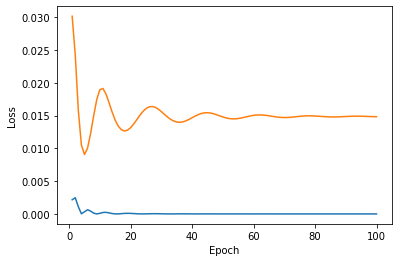

In [17]:
#We now want to see a graphical representation of the loss of our model
epoch = list(np.linspace(1,100,100,))
plt.plot(epoch, training_loss)
plt.plot(epoch,validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.close()